In [2]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [3]:
def mean(p, N):                         # Mean value of successes E(n)
    return p*N

def var(p, N):                          # Variance of successes V(n)
    return p*N*(1-p)

def sigma(p, N):
    return np.sqrt(var(p,N))/N                 

def Z(CL):
    return np.sqrt(2)*sp.erfinv(CL)     # Function that returns the number of sigmas for a given CL

def wald(n, N, CL, verbose=False):
    p_hat = n/N                         # Estimation of p as p = n / N = #successes / #experiments
    p_sigma = sigma(p_hat,N)            # Standard deviation of p
    z = Z(CL)
    interval = [p_hat - z*p_sigma, p_hat + z*p_sigma]  # Confidence interval for p in the Gaussian approximation
    if(verbose == True):
        print("The Wald confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval

def wilson(n, N, CL, verbose=False):   
    p_hat = n/N
    p_sigma = sigma(p_hat,N)
    z = Z(CL)
    step = 0.01
    p1 = p_hat                           #initialise
    p2 = p_hat                           #initialise
    while(p1 + z*sigma(p1,N) >= p_hat):
        p1-=step
    while(p_hat >= p2 - z*sigma(p2,N)):
        p2+=step
    interval = [p1, p2]  # Wilson confidence interval for p
    if(verbose == True):
        print("The Wilson confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval

def agresticoull(n,N,CL,verbose=False):
    int_wilson = wilson(n,N,CL)
    p_midpoint_wilson = (int_wilson[0]+int_wilson[1])/2
    p_sigma = sigma(p_midpoint_wilson,N) 
    z = Z(CL)
    interval = [p_midpoint_wilson - z*p_sigma, p_midpoint_wilson + z*p_sigma]  # Confidence interval for p in the Gaussian approximation
    if(verbose == True):
        print("The Agresti and Coull confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval
    

        

In [4]:
N = 10
n = 9
CL = 0.6827
z = Z(CL)

wald(n, N, CL, verbose=True)
wilson(n,N,CL, verbose=True)
agresticoull(n,N,CL, verbose=True)

The Wald confidence interval for p given 9 successes in 10 experiments is:
[0.8051296102882612, 0.9948703897117388]
The Wilson confidence interval for p given 9 successes in 10 experiments is:
[0.7599999999999999, 0.9700000000000001]
The Agresti and Coull confidence interval for p given 9 successes in 10 experiments is:
[0.7569351716784586, 0.9730648283215414]


[0.7569351716784586, 0.9730648283215414]

/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


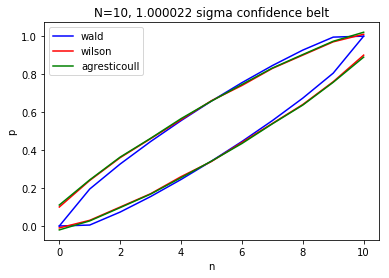

In [5]:
#prepare empty lists for the upper and lower limits for the three intervals
lower_wald = []
upper_wald = []
lower_wilson = []
upper_wilson = []
lower_agresticoull = []
upper_agresticoull = []

#n can range from 0 to N included
n_range = range(0,N+1)

for n in n_range:
    #wald limits
    lower_wald.append(wald(n,N,CL)[0])
    upper_wald.append(wald(n,N,CL)[1])
    #wilson limits
    lower_wilson.append(wilson(n,N,CL)[0])
    upper_wilson.append(wilson(n,N,CL)[1])
    #agresti and coull limits
    lower_agresticoull.append(agresticoull(n,N,CL)[0])
    upper_agresticoull.append(agresticoull(n,N,CL)[1])
    
#plot limits.. confidence belt?
plt.plot(n_range,lower_wald,label="wald", color='b')
plt.plot(n_range,upper_wald, color='b')
plt.plot(n_range,lower_wilson,label="wilson", color='r')
plt.plot(n_range,upper_wilson, color='r')
plt.plot(n_range,lower_agresticoull,label="agresticoull", color='g')
plt.plot(n_range,upper_agresticoull, color='g')
plt.xlabel("n")
plt.ylabel("p")
plt.title("N=%d, %f sigma confidence belt"% (n,z))

plt.legend(loc='best')


In [226]:
#Ex 3

CL = 0.6827

p = 0.1
N = 10
N_trials = 1000

def fraction_in_interval(p,N,N_trials):

    n_incl_wald = 0
    n_incl_wilson = 0
    n_incl_ac = 0

    n = np.random.binomial(N,p, size=N_trials)
    
    #check if p is included in interval
    
    for number in n:

        waldint = wald(number, N, CL)
        if(waldint[0] <= p <= waldint[1]):
            n_incl_wald+=1

        wilsonint = wilson(number, N, CL)
        if(wilsonint[0] <= p <= wilsonint[1]):
            n_incl_wilson+=1

        agresticoullint = agresticoull(number, N, CL)
        if(agresticoullint[0] <= p <= agresticoullint[1]):
            n_incl_ac+=1

    return([n_incl_wald/N_trials, n_incl_wilson/N_trials, n_incl_ac/N_trials])

In [227]:
wald_fractions = []
wilson_fractions = []
ac_fractions = []

#fixed N, varying p
for p in np.linspace(0,1,11):
    fractions = fraction_in_interval(p,N,N_trials)
    wald_fractions.append(fractions[0])
    wilson_fractions.append(fractions[1])
    ac_fractions.append(fractions[2])


/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


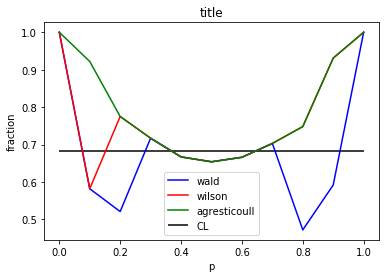

In [228]:
#plot

plt.plot(np.linspace(0,1,11), wald_fractions, label="wald",color='b')
plt.plot(np.linspace(0,1,11), wilson_fractions, label="wilson",color='r')
plt.plot(np.linspace(0,1,11), ac_fractions, label="agresticoull",color='g')
plt.hlines(CL,0,1,label="CL",color='black')
plt.xlabel("p")
plt.ylabel("fraction")
plt.title("title")

plt.legend(loc='best')

In [229]:
N_trials = 100

wald_fr_all = []
wilson_fr_all = []
ac_fr_all = []

N_initial = 2
N_final = 20

#vary N, vary p

for N in range(N_initial,N_final+1):
    
    wald_fractions = []
    wilson_fractions = []
    ac_fractions = []
    
    for p in np.linspace(0,1,11):
        fractions = fraction_in_interval(p,N,N_trials)
        wald_fractions.append(fractions[0])
        wilson_fractions.append(fractions[1])
        ac_fractions.append(fractions[2])
    
    #stack all fractions data for each interal method, for each N and for each p 
    if(N == N_initial):
        wald_fr_all = wald_fractions
        wilson_fr_all = wilson_fractions
        ac_fr_all = ac_fractions
    else:
        wald_fr_all = np.vstack((wald_fr_all,wald_fractions))
        wilson_fr_all = np.vstack((wilson_fr_all,wilson_fractions))
        ac_fr_all = np.vstack((ac_fr_all,ac_fractions))

/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [230]:
#shape the data in a more usable way for the 2d plots

wald_data = [[],[],[]]
wilson_data = [[],[],[]]
ac_data = [[],[],[]]

n_Ns = N_final-N_initial+1
n_ps = len(np.linspace(0,1,11))

for N1 in range(n_Ns):
    for p1 in range(n_ps):
        wald_data[0].append(p1/10)
        wald_data[1].append(N1+2)
        wald_data[2].append(wald_fr_all[N1][p1])
        
        wilson_data[0].append(p1/10)
        wilson_data[1].append(N1+2)
        wilson_data[2].append(wilson_fr_all[N1][p1])
        
        ac_data[0].append(p1/10)
        ac_data[1].append(N1+2)
        ac_data[2].append(ac_fr_all[N1][p1])
        

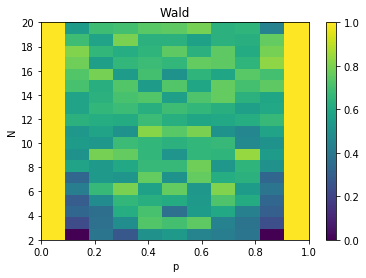

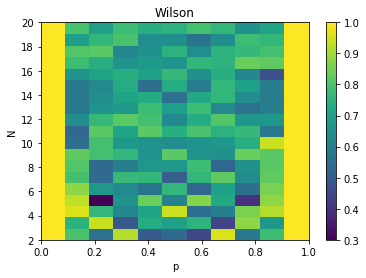

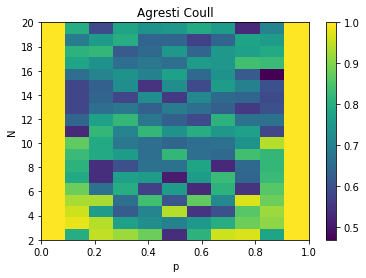

In [231]:
#2d plots 

plt.hist2d(wald_data[0],wald_data[1],weights=wald_data[2],bins=[11,19])
plt.colorbar()
plt.xlabel("p")
plt.ylabel("N")
plt.title("Wald")
plt.show()

plt.hist2d(wilson_data[0],wilson_data[1],weights=wilson_data[2],bins=[11,19])
plt.colorbar()
plt.xlabel("p")
plt.ylabel("N")
plt.title("Wilson")
plt.show()

plt.hist2d(ac_data[0],ac_data[1],weights=ac_data[2],bins=[11,19])
plt.colorbar()
plt.xlabel("p")
plt.ylabel("N")
plt.title("Agresti Coull")
plt.show()

In [232]:
#average as function of N

wald_av = []
wilson_av = []
ac_av = []

Nrange = range(N_initial,N_final+1)
npdata = len(np.linspace(0,1,11))

for N1 in Nrange:
    N1 = N1-2
    #arrays of coverage values for every p between 0 and 1 for given N
    wald_n_set = (wald_data[2])[(N1*npdata):((N1+1)*npdata)] 
    wilson_n_set = (wilson_data[2])[(N1*npdata):((N1+1)*npdata)]
    ac_n_set = (ac_data[2])[(N1*npdata):((N1+1)*npdata)]
    #find average coverage value
    wald_av.append(np.average(wald_n_set))
    wilson_av.append(np.average(wilson_n_set))
    ac_av.append(np.average(ac_n_set))


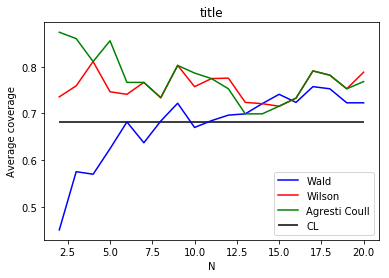

In [233]:
#plot

plt.plot(Nrange,wald_av, label="Wald", color='b')
plt.plot(Nrange,wilson_av, label="Wilson", color='r')
plt.plot(Nrange,ac_av, label="Agresti Coull", color='g')
plt.hlines(CL,Nrange[0],Nrange[-1], label="CL")
plt.legend()
plt.xlabel("N")
plt.ylabel("Average coverage")
plt.title("title")
plt.show()